# Dummy UNET

## Imports

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader, random_split

import time
from tqdm import tqdm

 
import os
import pickle as pkl
import numpy as np
import pandas as pd

import sys ; sys.path.append('..')  # useful if you're running locally

from matplotlib import pyplot as plt


In [ ]:
# import of local modules
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from dataset import dataset_dir
from cs import CompressedSensing, generate_sensing_matrix
from cs.utils import compute_rsnr
from models.unet import UNet

#### Set GPUs

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

os.environ['SCIPY_USE_PROPACK'] = "True"
 
threads = "64"
os.environ["OMP_NUM_THREADS"] = threads
os.environ["OPENBLAS_NUM_THREADS"] = threads
os.environ["MKL_NUM_THREADS"] = threads
os.environ["VECLIB_MAXIMUM_THREADS"] = threads
os.environ["NUMEXPR_NUM_THREADS"] = threads

## Parameters

In [58]:
N = 10_000
n = 128
m = 48
fs = 256
hr = [60, 100]
isnr = 35 # dB
seed = 0

supp_method = 'TSOC2'
mode_A = 'standard'
orth = True

## DATASET

In [ ]:
root = os.path.join('..', '..','newpenny','dnn-cs','tsoc','data')
str_ecg_setting = f'ecg_N={N}_n={n}_fs={fs}_hr={hr[0]}-{hr[1]}_isnr={isnr}_seed={seed}'

path_ecg = os.path.join(root, str_ecg_setting + '.pkl')
path_s_GR = os.path.join(root, str_ecg_setting, 'supports_method=GR_eta=0.9999.pkl')
path_s_standard = os.path.join(root, str_ecg_setting, f'supports_method={supp_method}_mode={mode_A}_m={m}_orth={orth}_seed={seed}.pkl')
path_corr = os.path.join('..', '..','newpenny','dnn-cs','tsoc','data','correlation', '96af96a7ddfcb2f6059092c250e18f2a.pkl')

In [ ]:
with open(path_ecg, 'rb') as f:
    ecg = pkl.load(f)
with open(path_s_standard, 'rb') as f:
    s = pkl.load(f)
with open(path_corr, 'rb') as f:
    corr = pkl.load(f)

In [ ]:
train_size = int(0.7 * len(ecg))
val_size = int(0.1 * len(ecg))
test_size = int(0.2 * len(ecg))
train_dataset, val_dataset, test_dataset = random_split(ecg, [train_size, val_size, test_size])

In [ ]:
# with open('mnist1d_data.pkl', 'rb') as f:
#     dataset = pkl.load(f)
#     x_train = dataset['x'][..., np.newaxis]
#     x_test = dataset['x_test'][..., np.newaxis]


### A generation

In [ ]:
A = np.random.normal(0, 1, (m, n))

In [5]:
def derive_things(x, xbar_index=[1], return_x=True, return_y=True):

    if x.shape[-1] != 1:
        x = np.swapaxes(x, -1, -2)
    y = A @ x

    outputs = []
    if return_x:
        outputs += [x]
    if return_y:
        outputs += [y]

    if 1 in xbar_index:
        outputs += [A.T @ y]
    if 2 in xbar_index:
        xbar2 =+ [np.linalg.pinv(A) @ y]

    if x.shape[-1] == 1:
        outputs = [np.swapaxes(i, -1, -2) for i in outputs]

    return outputs

In [6]:
x_train.shape

(4000, 40, 1)

In [7]:
x_train, y_train, xbar_train = derive_things(x_train)
x_val, y_val, xbar_val = derive_things(x_val)
x_test, y_test, xbar_test = derive_things(x_test)

channels = x_train.shape[-2]
print('x shape:', x_train.shape, '\ny shape:', y_train.shape, '\nxbar shape:', xbar_train.shape)

x shape: (4000, 1, 40) 
y shape: (4000, 1, 15) 
xbar shape: (4000, 1, 40)


## DATA LOADER

In [8]:
class Dataset_aug(torch.utils.data.Dataset):
    def __init__(self, train_input, train_output,mode='train'):
        self.train_input = train_input
        self.train_output = train_output
        self.mode = mode
        
    def __len__(self):
        return len(self.train_input)
    
    def _augmentations(self,input_data, target_data):
        #flip
        if np.random.rand()<0.5:    
            input_data = input_data[::-1]
            target_data = target_data[::-1]
        return input_data, target_data
    
    def __getitem__(self, idx):
        x = self.train_input[idx]
        y = self.train_output[idx]
        if self.mode =='train_aug':
            x,y = self._augmentations(x,y)

        out_y = torch.tensor(y.copy(), dtype=torch.float)
        out_x = torch.tensor(x.copy(), dtype=torch.float)
        
        # out_x = torch.tensor(np.transpose(x.copy(),(1,0)), dtype=torch.float)
        # out_y = torch.tensor(np.transpose(y.copy(),(1,0)), dtype=torch.float)
        return out_x, out_y

In [9]:
batch_size = 64
train = Dataset_aug(xbar_train, x_train, mode='train')
valid = Dataset_aug(xbar_val, x_val, mode='valid')
test = Dataset_aug(xbar_test, x_test, mode='test')

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

Early stopping parameters

In [10]:
early_stopping_patience = 20
best_val_loss = float('inf')
patience_counter = 0

GPU selection

In [11]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cpu device


## MODEL

In [ ]:
model = UNet(in_channels=channels, num_classes=channels,
                  channels=8, steps_num=2, kernel_size=3, residual=False,
                  use_batch_norm=False, simple_pool=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### to(GPU)

In [13]:
model = model.to(device)
for inputs, targets in train_loader:
    
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs)

## TRAINING

In [14]:
outputs.shape, targets.shape, inputs.shape

(torch.Size([32, 1, 40]), torch.Size([32, 1, 40]), torch.Size([32, 1, 40]))

In [17]:
num_epochs = 100
patience_counter = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    
    for data in train_loader:
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # calculate validation loss
    model.eval()
    val_loss = 0.0
    val_loss_list = []
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            val_loss_list += [val_loss]


    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    #print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ')
        #   f'Train SNR: {train_SNR:.2f}%, Val Accuracy: {val_SNR:.2f}%')
    
    # early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping: Validation loss hasn't improved for", early_stopping_patience, "epochs.")
            break


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


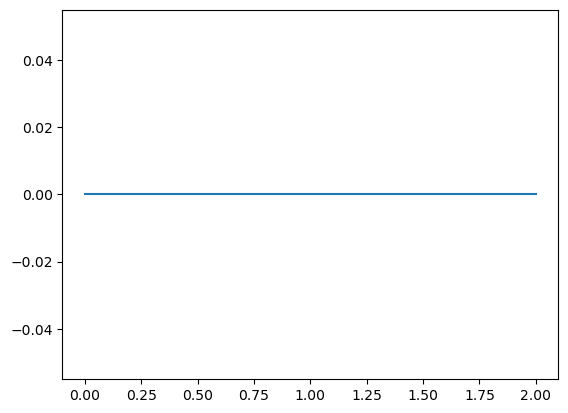

In [20]:
plt.plot(val_loss_list)

In [ ]:
## Hyperparameter
n_epochs = 100
lr = 0.001

##Loss function
loss_fn = torch.nn.MSELoss()

#Build model, initial weight and optimizer
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr,weight_decay=1e-5) # Using Adam optimizer
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.2, min_lr=1e-8) # Using ReduceLROnPlateau schedule
temp_val_loss = 1e5


In [ ]:


for epoch in range(n_epochs):
    
    start_time = time.time()
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        y_pred = model(x_batch.cuda())
        
        loss = loss_fn(y_pred.cpu(), y_batch)
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        avg_loss += loss.item()/len(train_loader)

        # pred = F.softmax(y_pred, 1).detach().cpu().numpy().argmax(axis=1)
        # train_preds[i * batch_size*train_input.shape[1]:(i+1) * batch_size*train_input.shape[1]] = pred.reshape((-1))
        # train_targets[i * batch_size*train_input.shape[1]:(i+1) * batch_size*train_input.shape[1]] = y_batch.detach().cpu().argmax(axis=1).reshape((-1))
        del y_pred, loss, x_batch, y_batch, pred
        
        
    model.eval()

    avg_val_loss = 0.
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch.cuda()).detach()

        avg_val_loss += loss_fn(y_pred.cpu(), y_batch).item() / len(valid_loader)
        pred = F.softmax(y_pred, 1).detach().cpu().numpy().argmax(axis=1)
        val_preds[i * batch_size*val_input.shape[1]:(i+1) * batch_size*val_input.shape[1]] = pred.reshape((-1))
        del y_pred, x_batch, y_batch, pred
        
    if avg_val_loss<temp_val_loss:
        #print ('checkpoint_save')
        temp_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'ION_train_checkpoint.pt')
        
    train_score = f1_score(train_targets,train_preds,average = 'macro')
    val_score = f1_score(val_target.argmax(axis=2).reshape((-1)),val_preds,average = 'macro')
    
    elapsed_time = time.time() - start_time 
    scheduler.step(avg_val_loss)
    
    print('Epoch {}/{} \t loss={:.4f} \t train_f1={:.4f} \t val_loss={:.4f} \t val_f1={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss,train_score, avg_val_loss,val_score, elapsed_time))

In [ ]:
n = 128

inp_shape = (1, 3, n)

input_image = torch.rand(inp_shape)


output = model(input_image)
print('output shape', output.size())

output shape torch.Size([1, 3, 128])


In [ ]:
x = torch.ones((1, 2, 4))
padding, out_padding = 0, 0
dilation = 1
nn.Conv1d(
    in_channels=2,
    out_channels=4,
    kernel_size=2,
    stride=2)(x).shape

torch.Size([1, 4, 2])

In [ ]:
x = torch.ones((1, 2, 4, 4))
padding, out_padding = 0, 0
dilation = 1
nn.ConvTranspose2d(
    in_channels=2,
    out_channels=2, 
    padding=padding, 
    dilation=dilation, 
    kernel_size=2, 
    stride=2,
    output_padding=out_padding)(x).shape

torch.Size([1, 2, 8, 8])

In [ ]:
in_channels, out_channels = 1, 4
kernel_size = (1, 3)
padding_size = (1, 1)
padding_size = 1

lconv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding_size)
lconv(x).shape



torch.Size([1, 4, 3, 128])